In [1]:
import json

In [75]:
with open('./ThomasGendt/1.json') as f:
    data = json.load(f)

print(data.keys())

dict_keys(['temp', 'latlng', 'velocity_smooth', 'grade_smooth', 'cadence', 'distance', 'altitude', 'watts_calc', 'time'])


In [6]:
import matplotlib.pyplot as plt

In [83]:
data['latlng'][0]

[43.696916, 7.271345]

In [133]:
stages = pd.read_csv('stages.txt')
stages.dtypes

stage_n       int64
lat         float64
long        float64
distance      int64
type         object
dtype: object

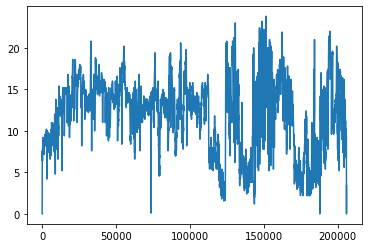

In [39]:
plt.plot(data['distance'],data['velocity_smooth'])

In [138]:
stages.lat[0]

43.743733

In [162]:
np.array(data).shape[0]

IndexError: tuple index out of range

In [149]:
np.array(data['latlng'])[:100,0]-stages.lat[0]

array([-0.046817, -0.046825, -0.046825, -0.046849, -0.046841, -0.046825,
       -0.04682 , -0.046816, -0.046811, -0.046807, -0.046802, -0.046798,
       -0.04679 , -0.046777, -0.046753, -0.046734, -0.046705, -0.046678,
       -0.046646, -0.046613, -0.046589, -0.046554, -0.046533, -0.046509,
       -0.046482, -0.04646 , -0.046434, -0.046409, -0.046388, -0.046361,
       -0.046345, -0.04631 , -0.046289, -0.046265, -0.046238, -0.046224,
       -0.0462  , -0.046182, -0.046165, -0.046144, -0.046117, -0.046093,
       -0.046066, -0.046053, -0.046037, -0.046021, -0.046002, -0.045986,
       -0.04598 , -0.045956, -0.045937, -0.045913, -0.045892, -0.045873,
       -0.045857, -0.045833, -0.045814, -0.045793, -0.045776, -0.045758,
       -0.045736, -0.04572 , -0.045693, -0.045661, -0.045637, -0.045621,
       -0.045597, -0.045565, -0.045532, -0.04549 , -0.045457, -0.045412,
       -0.045377, -0.045334, -0.045296, -0.045253, -0.045205, -0.04516 ,
       -0.045117, -0.045074, -0.045036, -0.045001, 

In [14]:
import pandas as pd
pd.DataFrame(data['watts_calc']).describe()

,0
count,20504.000000
mean,370.257657
std,336.366257
min,0.000000
25%,37.000000
50%,278.000000
75%,651.000000
max,1288.000000


In [17]:
df = pd.DataFrame(columns=['cyclist','stage','distance','time','avg_Temp', 'avg_V', 'top10_V', 'std_V', 'avg_gradient', 'top10_gradient', 'avg_cadence', 'top10_cadence', 'elevation_gain', 'avg_watts', 'top10_watts'])

In [221]:
stages = pd.read_csv('stages.txt')
stages.head()

,name,stage_n,lat,long,distance,type
0,Nice Moyen Pays > Nice,1,43.743733,7.270862,156,flat
1,Nice Haut Pays > Nice,2,43.705069,7.184564,186,mountain


In [223]:
stages.loc[1,'lat']

43.705069

In [23]:
import numpy as np
from scipy.integrate import cumtrapz
import pandas as pd
import json

def load_data(cyclist_row):
    stages = pd.read_csv('stages.txt')
    cyclist_data = pd.DataFrame(columns=['name','team','stage','distance','time','avg_Temp', 'avg_V', 'top25_V', 'std_V', 'avg_gradient', 'max_gradient', 'avg_cadence', 'top25_cadence', 'elevation_gain', 'avg_watts', 'top25_watts','stage_type'])
    ii = 1
    cyclist = cyclist_row.rider
    team = cyclist_row.team
    for i in range(1,22):
        try:
            with open('./'+cyclist+f'/{i}.json') as f:
                data = json.load(f)
            f.close()
            
            start_idx, end_idx = stage_distance(stages.loc[i-1,'lat'],stages.loc[i-1,'long'],stages.loc[i-1,'distance'], np.array(data['distance']),np.array(data['latlng']))
            stage = i
            # measured distance of stage
            distance = (data['distance'][end_idx]-data['distance'][start_idx])/1000
            # time duration of stage [h]
            time = (data['time'][end_idx]-data['time'][start_idx])/3600
            # average temperature
            
            avg_Temp = np.mean(data['temp'][start_idx:end_idx])
            avg_V = np.mean(data['velocity_smooth'][start_idx:end_idx])*3.6
            top25_V = np.quantile(data['velocity_smooth'][start_idx:end_idx],.75)*3.6
            std_V = np.std(data['velocity_smooth'][start_idx:end_idx])*3.6
            avg_gradient = np.mean(data['grade_smooth'][start_idx:end_idx])
            max_gradient = np.quantile(data['grade_smooth'][start_idx:end_idx],.9975)
            try:
                avg_cadence = np.mean(data['cadence'][start_idx:end_idx])
                top25_cadence = np.quantile(data['cadence'][start_idx:end_idx],.75)
            except:
                avg_cadence = np.nan
                top25_cadence = np.nan
            # compute elevation gain from positive altitude difference betweent 2 consecutive points
            x2 = np.array(data['altitude'][start_idx+1:end_idx])
            x1 = np.array(data['altitude'][start_idx:end_idx-1])
            elev = x2-x1
            elevation_gain = sum([y for y in elev if y>0])
            power = cumtrapz(data['watts_calc'][start_idx:end_idx],data['time'][start_idx:end_idx])/data['time'][start_idx+1:end_idx]#[1:]
            avg_watts =  np.mean(power)#np.mean(data['watts_calc'])
            top25_watts = np.quantile(power,.75)# np.quantile(data['watts_calc'],.75)
            stage_type = stages.loc[i-1,'type']
            cyclist_data.loc[ii,:] = [cyclist,team, stage, distance, time, avg_Temp, avg_V, top25_V, std_V, avg_gradient, max_gradient, avg_cadence, top25_cadence, elevation_gain, avg_watts, top25_watts,stage_type]
            ii += 1
        except:
            print(f'No stage {i} for '+cyclist)
    return cyclist_data

def stage_distance(stage_lat, stage_lng, stage_dist, cyclist_distance, cyclist_position):
    # look for beginning of stage from initial 10% points
    begin_len = int(0.10*cyclist_distance.shape[0])
    # get index from proximity to stage gps coordinates start
    start_idx = np.argmin((
        (cyclist_position[:begin_len,0]-stage_lat)**2 + 
        (cyclist_position[:begin_len,1]-stage_lng)**2)**0.5)
    # get end of stage index from nominal distance
    #km0 = data['distance'][start_idx]
    km0 = cyclist_distance[start_idx]
    kmfinish = (stage_dist)*1000
    end_idx = np.argmin(np.abs(cyclist_distance-km0-kmfinish))
    #if (cyclist_distance[end_idx]-km0<stage_dist*1000):
    #    print(cyclist_distance[end_idx],km0,stage_dist*1000)
    #    start_idx = np.argmin(np.abs(cyclist_distance[end_idx]-stage_dist*1000))
    return start_idx, end_idx

In [24]:
cyclists = pd.read_csv('cyclists.txt')
df = pd.DataFrame(columns=['name','team','stage','distance','time','avg_Temp', 'avg_V', 'top25_V', 'std_V', 'avg_gradient', 'max_gradient', 'avg_cadence', 'top25_cadence', 'elevation_gain', 'avg_watts', 'top25_watts','stage_type'])
for i in range(len(cyclists)):
    df = df.append(load_data(cyclists.loc[i,:]))
df

No stage 3 for Tadej Pogacar
No stage 5 for Tadej Pogacar
No stage 6 for Tadej Pogacar
No stage 7 for Tadej Pogacar
No stage 11 for Tadej Pogacar
No stage 16 for Tadej Pogacar
No stage 19 for Tadej Pogacar
No stage 20 for Tadej Pogacar
No stage 21 for Tadej Pogacar
No stage 5 for Bryan Coquard
No stage 10 for Bryan Coquard
No stage 1 for Jerome Cousin
No stage 16 for Jerome Cousin
No stage 17 for Jerome Cousin
No stage 18 for Jerome Cousin
No stage 19 for Jerome Cousin
No stage 20 for Jerome Cousin
No stage 21 for Jerome Cousin
No stage 20 for Rigoberto Uran
No stage 21 for Rigoberto Uran


,name,team,stage,distance,time,avg_Temp,avg_V,top25_V,std_V,avg_gradient,max_gradient,avg_cadence,top25_cadence,elevation_gain,avg_watts,top25_watts,stage_type
1,Thomas de Gendt,Lotto-Soudal,1,155.217,4.045,22.8168,38.4609,48.24,11.7402,0.302575,10.3,70.26,91,1281,253.284,297.242,flat
2,Thomas de Gendt,Lotto-Soudal,2,183.173,5.4325,28.9118,33.7097,46.8,16.167,2.06194,15.4,69.9496,88,3520,269.343,293.931,mountain
3,Thomas de Gendt,Lotto-Soudal,3,196.237,5.37056,22.9027,36.8653,48.24,13.9582,0.796315,12,66.6538,87,2138,265.94,284.053,flat
4,Thomas de Gendt,Lotto-Soudal,4,157.877,4.15111,23.3687,38.0324,46.8,13.9099,2.05124,13.3,74.4609,90,3119,314.749,351.248,hilly
5,Thomas de Gendt,Lotto-Soudal,5,181.134,4.47083,29.2721,40.5807,48.24,11.7373,0.174138,8.7,67.2378,88,1402,254.596,281.483,flat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,Rigoberto Uran,Education First Pro Cycling,15,174.502,4.70556,28.9233,37.8921,51.48,17.0377,2.92494,23.0638,NaN,NaN,3507.4,365.102,393.286,mountain
16,Rigoberto Uran,Education First Pro Cycling,16,162.469,4.49528,28.6762,36.1847,48.6,16.9692,2.43541,13,NaN,NaN,3454.6,385.399,407.563,mountain
17,Rigoberto Uran,Education First Pro Cycling,17,168.414,4.87333,27.597,34.5163,46.44,16.1992,3.32029,20.0425,NaN,NaN,4101.4,364.487,389.079,mountain
18,Rigoberto Uran,Education First Pro Cycling,18,172.836,4.89528,25.3005,35.1899,50.4,18.4674,2.73623,19.4952,NaN,NaN,4345.8,282.397,303.081,mountain


In [25]:
df = df.astype({'distance':'float','time':'float','avg_gradient':'float','max_gradient':'float','elevation_gain':'float'})
df.dtypes

name               object
team               object
stage              object
distance          float64
time              float64
avg_Temp           object
avg_V              object
top25_V            object
std_V              object
avg_gradient      float64
max_gradient      float64
avg_cadence        object
top25_cadence      object
elevation_gain    float64
avg_watts          object
top25_watts        object
stage_type         object
dtype: object

In [31]:
df.groupby('stage')['avg_gradient'].mean().values

array([0.25564896, 1.97766787, 1.15799264, 2.14911786, 0.16671445,
       2.0129966 , 0.85952584, 3.08057635, 2.71953568, 0.16249225,
       0.35747141, 1.45522951, 2.81659953, 1.03674378, 3.26082192,
       2.4992255 , 3.52579788, 2.88022686, 0.83079578, 3.79779933,
       0.42390292])

In [47]:
stages = pd.read_csv('stages.csv',index_col=0)
stages.head()

,Stage,Date,Start,Finish,Distance,Terrain,profile_score,elevation_gain,avg_gradient,max_gradient,sprint_pts,kom_pts
0,1,August 29,Nice Moyen Pays,Nice,156,Flat,36.0,1514.820000,0.255649,9.902800,336,6
1,2,August 30,Nice Haut Pays,Nice,187,Mountain,153.0,3529.900000,1.977668,14.157417,319,73
2,3,August 31,Nice,Sisteron,198,Flat,48.0,2604.720000,1.157993,12.599000,336,10
3,4,September 1,Sisteron,Orcières-Merlette,157,Hilly,173.0,3142.933333,2.149118,12.940458,319,41
4,5,September 2,Gap,Privas,183,Flat,14.0,1383.550000,0.166714,7.927125,336,2


In [60]:
stages.to_csv('stages.csv')

In [59]:
stages = stages.astype({'koms':'int','sprints':'int'})
stages.head(21)

,Stage,Date,Start,Finish,Distance,Terrain,profile_score,elevation_gain,avg_gradient,max_gradient,sprint_pts,kom_pts,koms,sprints
0,1,August 29,Nice Moyen Pays,Nice,156,Flat,36.0,1514.820000,0.255649,9.902800,336,6,2,2
1,2,August 30,Nice Haut Pays,Nice,187,Mountain,153.0,3529.900000,1.977668,14.157417,319,73,3,2
2,3,August 31,Nice,Sisteron,198,Flat,48.0,2604.720000,1.157993,12.599000,336,10,4,2
3,4,September 1,Sisteron,Orcières-Merlette,157,Hilly,173.0,3142.933333,2.149118,12.940458,319,41,5,2
4,5,September 2,Gap,Privas,183,Flat,14.0,1383.550000,0.166714,7.927125,336,2,2,2
5,6,September 3,Le Teil*,Mont Aigoual*,191,Hilly,209.0,3075.440000,2.012997,17.877500,319,37,3,2
6,7,September 4,Millau,Lavaur,168,Hilly,33.0,2059.320000,0.859526,11.522150,336,7,3,2
7,8,September 5,Cazères-sur-Garonne*,Loudenvielle,140,Mountain,263.0,3624.766667,3.080576,16.997208,262,139,3,2
8,9,September 6,Pau,Laruns,154,Mountain,212.0,3274.300000,2.719536,20.634458,262,69,5,2
9,10,September 8,The Chateau d’Oleron,Ile de Re Saint-Martin-de-Re*,170,Flat,1.0,982.840000,0.162492,10.181200,336,0,0,2


In [56]:
stages['sprints']=cyclists_data.groupby('stage_no').mean()['sprints'].values

In [48]:
cyclists_data = pd.read_csv('data_full.csv',index_col=0)
cyclists_data.head(20)

,GC,GC-Time,BIB,Rider,Age,Team,UCI,Pnt,Time,sprint_pts,kom_pts,stage_no,sprints,koms,Avg
Rnk,,,,,,,,,,,,,,,
1,1.0,+0:00,135,kristoff alexander,33,UAE-Team Emirates,120.0,100.0,3:46:233:46:23,59,0,1,2,2,NaN
2,2.0,+0:04,105,pedersen mads,24,Trek - Segafredo,50.0,70.0,",,0:00",30,0,1,2,2,NaN
3,3.0,+0:06,203,bol cees,25,Team Sunweb,25.0,50.0,",,0:00",20,0,1,2,2,NaN
4,4.0,+0:10,43,bennett sam,29,Deceuninck - Quick Step,15.0,40.0,",,0:00",28,0,1,2,2,NaN
5,5.0,+0:10,21,sagan peter,30,BORA - hansgrohe,5.0,32.0,",,0:00",29,0,1,2,2,NaN
6,6.0,+0:10,128,viviani elia,31,"Cofidis, Solutions Crédits",NaN,26.0,",,0:00",14,0,1,2,2,NaN
7,7.0,+0:10,191,nizzolo giacomo,31,NTT Pro Cycling,NaN,22.0,",,0:00",12,0,1,2,2,NaN
8,8.0,+0:10,211,coquard bryan,28,B&B Hotels - Vital Concept p/b KTM,NaN,18.0,",,0:00",18,0,1,2,2,NaN
9,9.0,+0:10,188,turgis anthony,26,Team Total Direct Energie,NaN,14.0,",,0:00",8,0,1,2,2,NaN


In [46]:
stages.to_csv('stages.csv')

In [286]:
#for HTTP request
import requests

url = f'https://www.strava.com/api/v3/activities/4021435252/streams?keys=time,distance,latlng,altitude,velocity_smooth,cadence,watts,temp,grade_smooth&key_by_type=true'
header = {'Authorization':'Bearer ' + f'[[{api_key}]]'}
requests.get(url, headers=header)

<Response [401]>

In [294]:
auth_url = 'https://www.strava.com/oauth/token'

payload = {
    'client_id':'53810',
    'client_secret': 'd6a4cf03a0891226c5cfe4908927015cf374e652',
    'refresh_token':'e6c9d2e8af6d75d325bc4e81b3eb2673dfdc7dbf',
    'grant_type':'refresh_token',
    'f':'json'
}

res = requests.post(auth_url,data=payload,verify=False)
access_token = res.json()['access_token']

In [342]:
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='output.html')

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 40.00it/s]
